In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,shutil
import cv2
import zipfile
import imutils

%matplotlib inline
plt.style.use('ggplot')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

## Preprocessing:

In [5]:
def unzip_file(file_path):
    z = zipfile.ZipFile(file_path)
    z.extractall()
    print('zip file is extracted')

In [6]:
def rename_files(unzip_path,ext,category):
    count = 1
    for filename in os.listdir(unzip_path):
        source = unzip_path + filename
        destination = unzip_path + category + "_" + str(count) + ext
        os.rename(source, destination)
        count+=1
    print("All files are renamed in the " + category + " dir.")

In [7]:
unzip_file('./data/archive.zip')

zip file is extracted


In [8]:
yes_path = 'brain_tumor_dataset/yes/'
no_path = 'brain_tumor_dataset/no/'

rename_files(yes_path, '.jpg', 'Yes')
rename_files(no_path, '.jpg', 'No')

All files are renamed in the Yes dir.
All files are renamed in the No dir.


In [9]:
def count_of_image(file_path):
    listyes = os.listdir(file_path)
    number_files = len(listyes)
    return number_files

In [10]:
count_of_image(yes_path) , count_of_image(no_path)

(155, 98)

In [11]:
def display_data(yes_path,no_path):
    types = ('tumor','non_tumor')
    values = (count_of_image(yes_path) , count_of_image(no_path))

    fig = plt.figure(figsize=(5,7))
    plt.bar(types, values, color="green")
    plt.xlabel("Data")
    plt.ylabel("Number of Brain Tumor Images")
    plt.title("Count of Brain Tumor Images")
    plt.show()

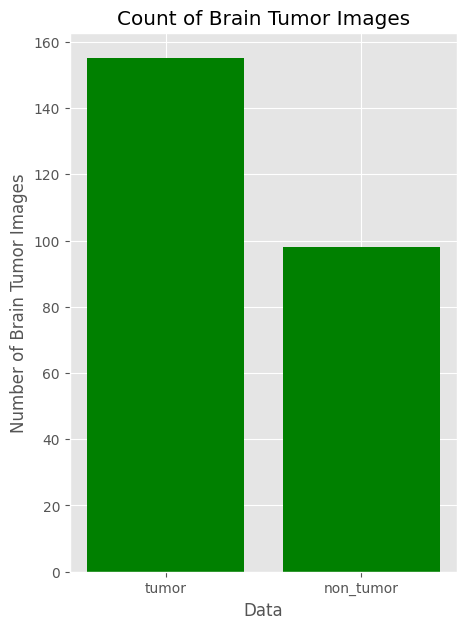

In [12]:
display_data(yes_path,no_path)

In [13]:
def create_augmented_data(file_dir, n_gen_img, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range = 10,
                      width_shift_range = 0.1,
                      height_shift_range = 0.1,
                      shear_range = 0.1,
                      brightness_range = (0.3, 1.0),
                      horizontal_flip = True,
                      vertical_flip = True,
                      fill_mode = 'nearest')
    for filename in os.listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        image = image.reshape((1,) + image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x = image, batch_size = 1, save_to_dir = save_to_dir, save_prefix = save_prefix, save_format = "jpg"):
            i += 1
            if i > n_gen_img:
                break

In [14]:
def check_path(root,sub_folders=None):
    if not(os.path.isdir(root)):
        os.mkdir(root)
        if sub_folders:
          for f in sub_folders:
              os.mkdir(os.path.join(root,f))
        print('Paths are created')

In [15]:
augmented_data_path = 'augmented_data'
check_path(augmented_data_path,['yes','no'])
create_augmented_data(yes_path, 6, os.path.join(augmented_data_path,'yes'))
create_augmented_data(no_path, 9, os.path.join(augmented_data_path,'no'))

Paths are created


In [16]:
def data_summary(root):
    n_pos = len(os.listdir(os.path.join(root,'yes')))
    n_neg = len(os.listdir(os.path.join(root,'no')))
    n = (n_pos + n_neg)
    pos_per = (n_pos*100)/n
    neg_per = (n_neg*100)/n
    print(f"Number of sample: {n}")
    print(f"{n_pos} Number of positive: {np.round(pos_per,2)}%")
    print(f"{n_neg} Number of negative: {np.round(neg_per,2)}%")

In [17]:
data_summary(augmented_data_path)

Number of sample: 2064
1085 Number of positive: 52.57%
979 Number of negative: 47.43%


In [18]:
count_of_image(os.path.join(augmented_data_path,'yes')),count_of_image(os.path.join(augmented_data_path,'no'))

(1085, 979)

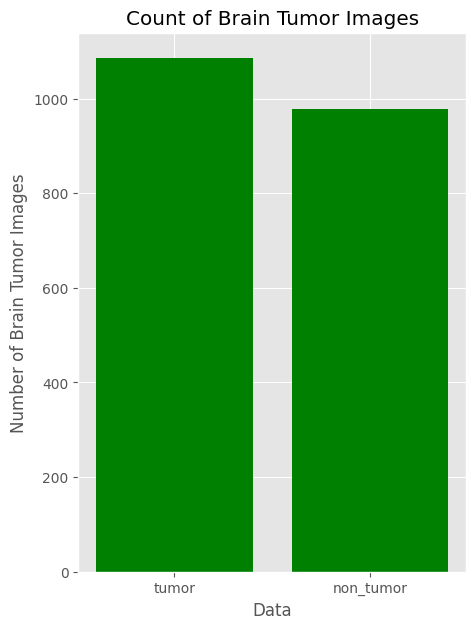

In [19]:
display_data(os.path.join(augmented_data_path,'yes'),os.path.join(augmented_data_path,'no'))

In [21]:
def crop_brain_tumor(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5,5), 0)
    thres = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thres =cv2.erode(thres, None, iterations = 2)
    thres = cv2.dilate(thres, None, iterations = 2)
    cnts = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key = cv2.contourArea)
    extLeft = tuple(c[c[:,:,0].argmin()][0])
    extRight = tuple(c[c[:,:,0].argmax()][0])
    extTop = tuple(c[c[:,:,1].argmin()][0])
    extBot = tuple(c[c[:,:,1].argmax()][0])

    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
    return new_image

In [22]:
lst_no_path = [f for f in os.listdir('augmented_data/no/')]

array([[[14, 14, 14],
        [14, 14, 14],
        [14, 14, 14],
        ...,
        [15, 15, 15],
        [15, 15, 15],
        [15, 15, 15]],

       [[14, 14, 14],
        [14, 14, 14],
        [14, 14, 14],
        ...,
        [15, 15, 15],
        [15, 15, 15],
        [15, 15, 15]],

       [[14, 14, 14],
        [14, 14, 14],
        [14, 14, 14],
        ...,
        [15, 15, 15],
        [15, 15, 15],
        [15, 15, 15]],

       ...,

       [[47, 47, 47],
        [47, 47, 47],
        [47, 47, 47],
        ...,
        [47, 47, 47],
        [47, 47, 47],
        [47, 47, 47]],

       [[47, 47, 47],
        [47, 47, 47],
        [47, 47, 47],
        ...,
        [47, 47, 47],
        [47, 47, 47],
        [47, 47, 47]],

       [[47, 47, 47],
        [47, 47, 47],
        [47, 47, 47],
        ...,
        [47, 47, 47],
        [47, 47, 47],
        [47, 47, 47]]], dtype=uint8)
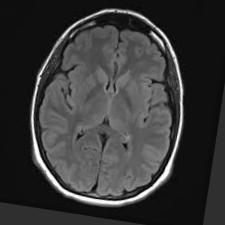

In [23]:
img = cv2.imread('augmented_data/no/' + lst_no_path[np.random.randint(0,len(lst_no_path))])
img

array([[[15, 15, 15],
        [15, 15, 15],
        [15, 15, 15],
        ...,
        [15, 15, 15],
        [15, 15, 15],
        [15, 15, 15]],

       [[15, 15, 15],
        [15, 15, 15],
        [15, 15, 15],
        ...,
        [15, 15, 15],
        [15, 15, 15],
        [15, 15, 15]],

       [[15, 15, 15],
        [15, 15, 15],
        [15, 15, 15],
        ...,
        [15, 15, 15],
        [15, 15, 15],
        [15, 15, 15]],

       ...,

       [[12, 12, 12],
        [12, 12, 12],
        [12, 12, 12],
        ...,
        [14, 14, 14],
        [14, 14, 14],
        [14, 14, 14]],

       [[13, 13, 13],
        [15, 15, 15],
        [15, 15, 15],
        ...,
        [14, 14, 14],
        [14, 14, 14],
        [14, 14, 14]],

       [[11, 11, 11],
        [ 9,  9,  9],
        [ 8,  8,  8],
        ...,
        [14, 14, 14],
        [14, 14, 14],
        [14, 14, 14]]], dtype=uint8)
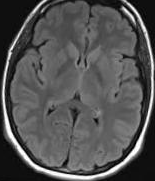

In [24]:
croped_img = crop_brain_tumor(img)
croped_img

In [25]:
def load_data(dir_list, image_size):
    X,y = [],[]
    image_width, image_height = image_size
    for dir in dir_list:
        for filename in os.listdir(dir):
            image = cv2.imread(dir + '/' + filename)
            image = crop_brain_tumor(image)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation = cv2.INTER_CUBIC)
            image = image/255.00
            X.append(image)
            if "yes" in dir:
                y.append(1)
            else:
                y.append(0)
    X = np.array(X)
    y = np.array(y)
    X,y = shuffle(X,y)
    print(f"Number of example is : {len(X)}")
    print(f"X SHAPE is : {X.shape}")
    print(f"y SHAPE is : {y.shape}")
    return X,y

In [26]:
augmented_path = 'augmented_data'
IMAGE_WIDTH, IMAGE_HEIGHT = (240,240)
X,y = load_data([os.path.join(augmented_path,'yes'), os.path.join(augmented_path,'no')], (IMAGE_WIDTH, IMAGE_HEIGHT))

Number of example is : 2064
X SHAPE is : (2064, 240, 240, 3)
y SHAPE is : (2064,)


In [27]:
def plot_sample_images(X, y, n=50):
    for label in [0,1]:
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        col_n = 10
        row_n = int(n/col_n)
        plt.figure(figsize=(20, 10))
        for i,image in enumerate(n_images,start=1):
            plt.subplot(row_n, col_n, i)
            plt.imshow(image[0])
            plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,
                            labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

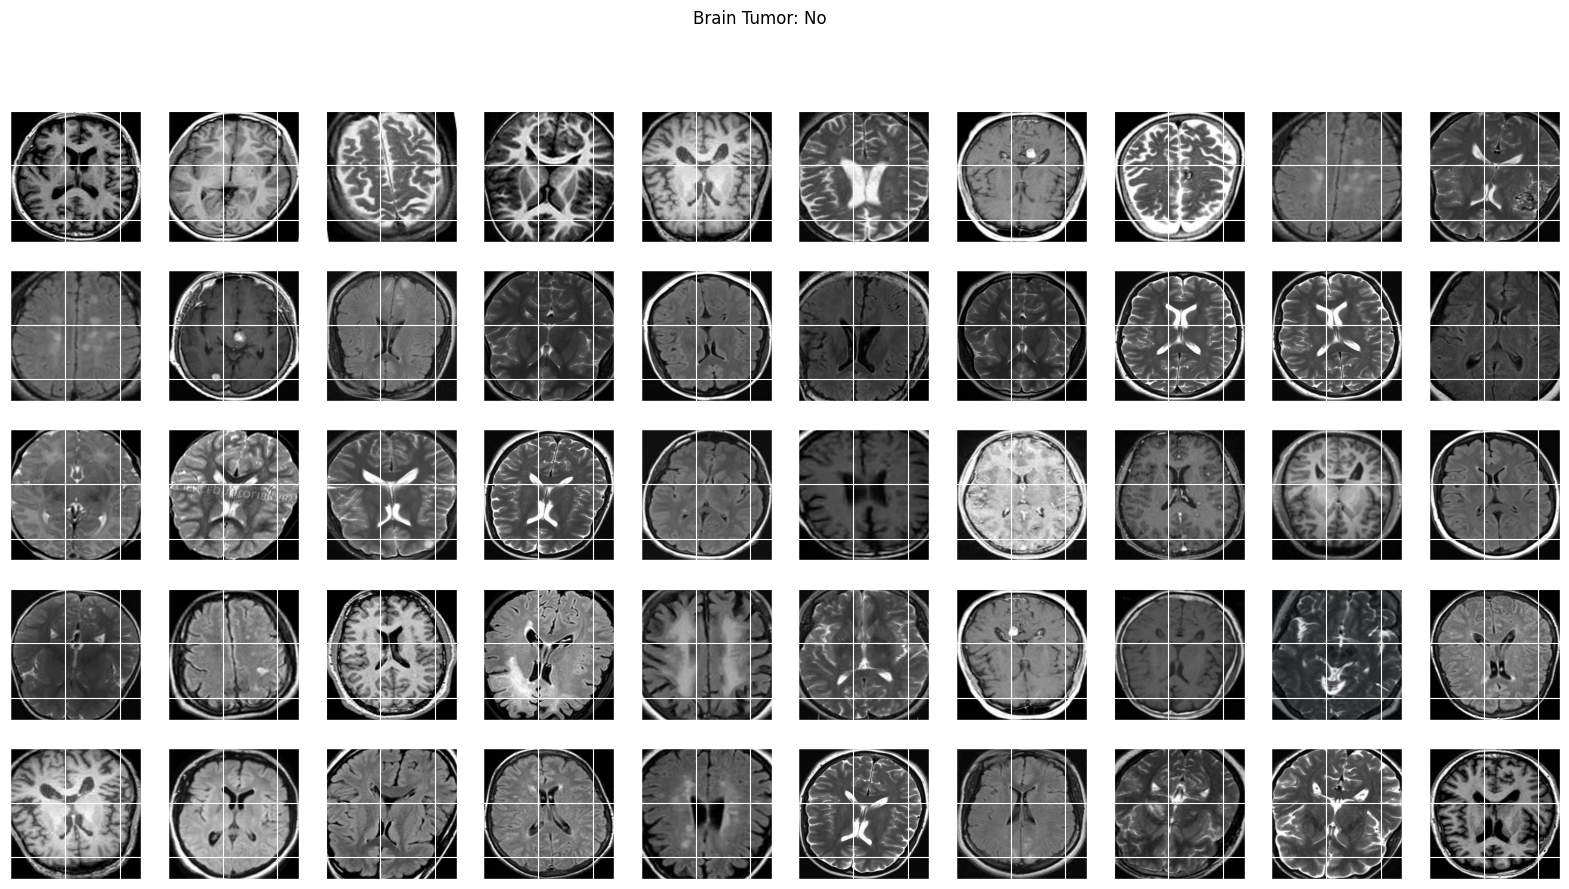

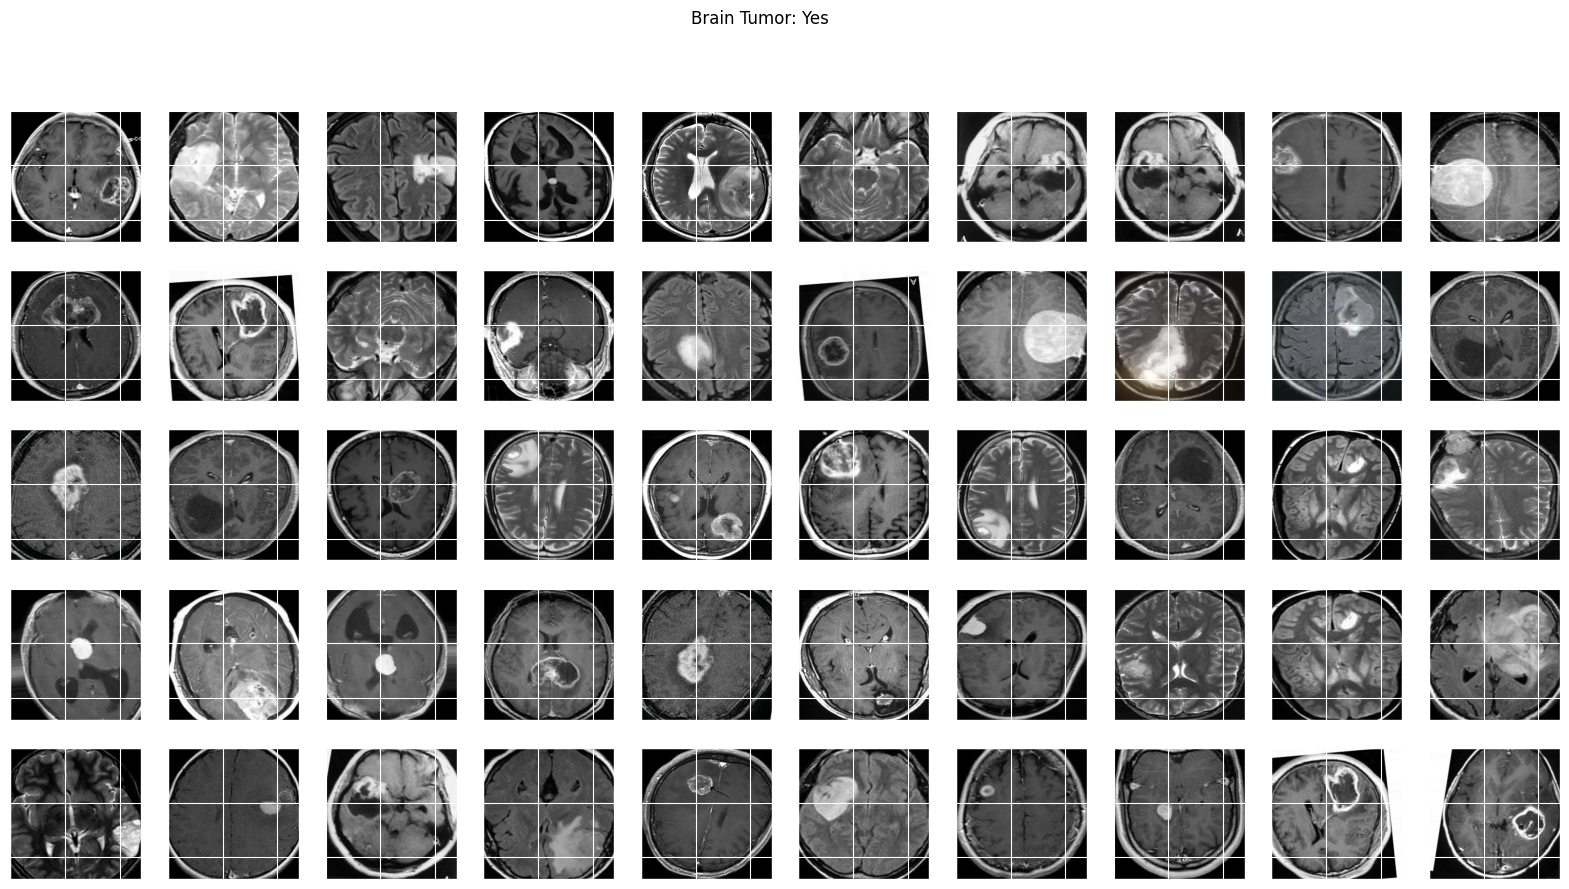

In [28]:
plot_sample_images(X,y)

In [29]:
check_path('tumorous_and_nontumorous',['train','valid','test'])

Paths are created


In [30]:
for f in ['train','valid','test']:
  check_path(os.path.join(os.path.join('tumorous_and_nontumorous',f),'tumor'))
  check_path(os.path.join(os.path.join('tumorous_and_nontumorous',f),'nontumor'))

Paths are created
Paths are created
Paths are created
Paths are created
Paths are created
Paths are created


In [35]:
def get_img_path(root):
  path_files, kind = [],[]
  for f in os.listdir(root):
    for img in os.listdir(os.path.join(root,f)):
      p = os.path.join(os.path.join(root,f),img)
      path_files.append(p)

  for p in path_files:
    if 'No' in p:
      kind.append(0)
    elif 'Yes' in p:
      kind.append(1)
  return np.array(path_files),np.array(kind)

In [38]:
X_path,y_path = get_img_path(augmented_path)
len(X_path),len(y_path)

(2064, 2064)

In [40]:
def copy_target_image(X,y,target_path):
  X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size = 0.1,shuffle = True)
  X_train,X_test,y_train,y_test = train_test_split(X_train,y_train,test_size = 0.1,shuffle = True)

  for i in ['train','valid','test']:
    dst = os.path.join(target_path,i)
    if i == 'train':
      for j in range(len(y_train)):
        if y_train[j] == 1:
          new_dst = os.path.join(os.path.join(dst,'tumor') , str(j) + "_yes.jpg")
          shutil.copyfile(X_train[j], new_dst)
        else:
          new_dst =  os.path.join(os.path.join(dst,'nontumor') , str(j) + "_no.jpg")
          shutil.copyfile(X_train[j], new_dst)
    if i == 'valid':
      for j in range(len(y_valid)):
        if y_valid[j] == 1:
          new_dst =  os.path.join(os.path.join(dst,'tumor') , str(j) + "_yes.jpg")
          shutil.copyfile(X_valid[j], new_dst)
        else:
          new_dst =  os.path.join(os.path.join(dst,'nontumor') , str(j) + "_no.jpg")
          shutil.copyfile(X_valid[j], new_dst)
    if i == 'test':
      for j in range(len(y_test)):
        if y_test[j] == 1:
          new_dst =  os.path.join(os.path.join(dst,'tumor') , str(j) + "_yes.jpg")
          shutil.copyfile(X_test[j], new_dst)
        else:
          new_dst =  os.path.join(os.path.join(dst,'nontumor') , str(j) + "_no.jpg")
          shutil.copyfile(X_test[j], new_dst)

In [41]:
copy_target_image(X_path,y_path,'tumorous_and_nontumorous')

## Model:

In [42]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                  horizontal_flip=0.4,
                  vertical_flip=0.4,
                  rotation_range=40,
                  shear_range=0.2,
                  width_shift_range=0.4,
                  height_shift_range=0.4,
                  fill_mode='nearest')
test_data_gen = ImageDataGenerator(rescale=1.0/255)
valid_data_gen = ImageDataGenerator(rescale=1.0/255)

In [43]:
train_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/train/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')


Found 1671 images belonging to 2 classes.


In [44]:
test_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/test/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')


Found 186 images belonging to 2 classes.


In [45]:
valid_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/valid/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')


Found 207 images belonging to 2 classes.


In [46]:
class_labels = train_generator.class_indices
class_name = {value: key for (key,value) in class_labels.items()}

In [47]:
class_name

{0: 'nontumor', 1: 'tumor'}

In [48]:
base_model = VGG19(input_shape = (240,240,3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable=False

flat = Flatten()(base_model.output)
layer_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(layer_1)
layer_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(layer_2)

model1 = Model(base_model.input, output)
model1.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 240, 240, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 240, 240, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 120, 120, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 120, 120, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 120, 120, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 60, 60, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 60, 60, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 30, 30, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 15, 15, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 140,946,370 (537.67 MB)

 Trainable params: 120,921,986 (461.28 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [49]:
filepath = 'model.h5'
es = EarlyStopping(monitor='val_loss', verbose = 1, mode='min',patience=4)
cp = ModelCheckpoint(filepath, monitor='val_loss', verbose = 1, save_best_only=True, save_weights_only=False, mode='auto',save_freq='epoch')
lrr = ReduceLROnPlateau(monitor='val_accuarcy', patience=3, verbose = 1, factor = 0.5, min_lr = 0.0001)

In [50]:
sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum = 0.9, nesterov = True)
model1.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
history1 = model1.fit(train_generator, steps_per_epoch=10, epochs = 2, callbacks=[es,cp,lrr], validation_data=valid_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2


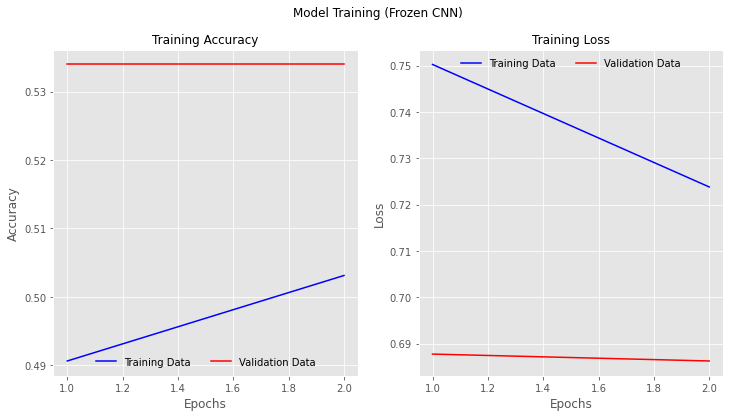

In [ ]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
fig.suptitle("Model Training (Frozen CNN)", fontsize=12)
max_epoch = len(history1.history['accuracy'])+1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history1.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history1.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history1.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history1.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)
plt.savefig("training_frozencnn.jpeg", format='jpeg', dpi=100, bbox_inches='tight')

In [ ]:
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model1.save_weights(filepath="model_weights/vgg19_model_01.h5", overwrite=True)

In [ ]:
model1.load_weights("model_weights/vgg19_model_01.h5")
vgg_val_eval_01 = model1.evaluate(valid_generator)
vgg_test_eval_01 = model1.evaluate(test_generator)

10/10 [==============================] - 87s 9s/step - loss: 0.7236 - accuracy: 0.4968
